# Mismatch between TWSA<sub>GLDAS</sub> and TWSA<sub>GRACE</sub>


In [1]:
#!pip install geopandas rasterio rioxarray xarray numpy

import geopandas as gpd
import rioxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
import pandas as pd
import xskillscore as xs

#### 1. Read data

In [2]:
ds_grace = xr.open_mfdataset('./data/GRACE/TWSA_M_2002_2016_India_05.nc4')
ds_gldas = xr.open_mfdataset('./data/GLDAS/processed/TWSA_M_2002_2016_India_03125.nc4')

da_grace = ds_grace['twsa_grace']
da_gldas = ds_gldas['twsa_gldas']

# for some reason, projection info is not saved -> temporary fix
da_gldas.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
da_gldas.rio.write_crs('epsg:4326', inplace=True)

<xarray.DataArray 'twsa_gldas' (time: 177, lat: 128, lon: 128)> Size: 12MB
dask.array<open_dataset-twsa_gldas, shape=(177, 128, 128), dtype=float32, chunksize=(177, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 1kB 60.16 60.47 60.78 61.09 ... 99.22 99.53 99.84
  * lat          (lat) float64 1kB 47.59 47.28 46.97 46.66 ... 8.531 8.219 7.906
  * time         (time) datetime64[ns] 1kB 2002-04-15 2002-05-15 ... 2016-12-15
    spatial_ref  int64 8B 0
Attributes:
    grid_mapping:  spatial_ref

#### 2. Plot time series for an example location in NW India (30N 80E)

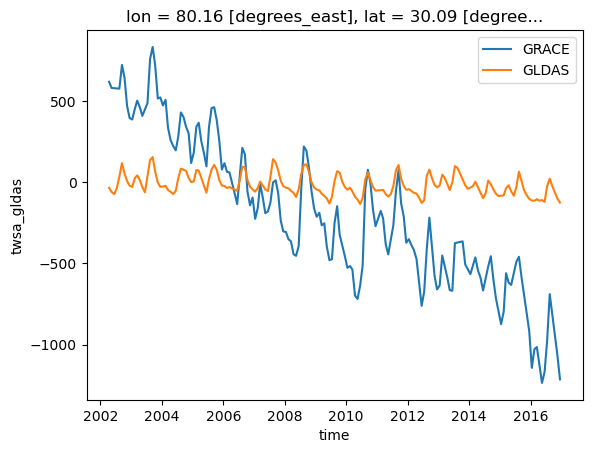

In [3]:
da_grace.sel(lat=30, lon=80, method='nearest').plot(label="GRACE")
da_gldas.sel(lat=30, lon=80, method='nearest').plot(label="GLDAS")
plt.legend()

#### 3. Calculate the difference without resampling

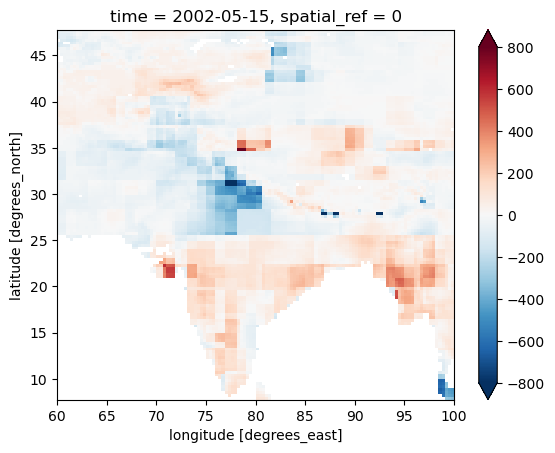

In [4]:
lat_gldas = da_gldas['lat'].values
lat_grace = da_grace['lat'].values
lon_gldas = da_gldas['lon'].values
lon_grace = da_grace['lon'].values

# Function to find the index of the nearest value in an array
def find_nearest_index(array, values):
    idx = np.abs(array[:, np.newaxis] - values).argmin(axis=0)
    return idx

# Find the indices of the nearest latitudes and longitudes
nearest_lat_indices = find_nearest_index(lat_grace, lat_gldas)
nearest_lon_indices = find_nearest_index(lon_grace, lon_gldas)

# calculate the difference
difference = da_gldas.to_numpy() - da_grace[:, nearest_lat_indices, nearest_lon_indices].to_numpy()

# Create a DataArray for the difference
difference_da = xr.DataArray(difference, coords=da_gldas.coords, dims=da_gldas.dims)
difference_da[1,:,:].plot(vmin=-800, vmax=800, cmap='RdBu_r')

#### 4. Calculate the difference with resampling

In [5]:
upscale_factor =  da_gldas.shape[1] / da_grace.shape[1]
new_width = int(da_grace.rio.width * upscale_factor)
new_height = int(da_grace.rio.height * upscale_factor)

resampled_da_grace = da_grace.rio.reproject_match(da_gldas).rename({'x': 'lon','y': 'lat'})

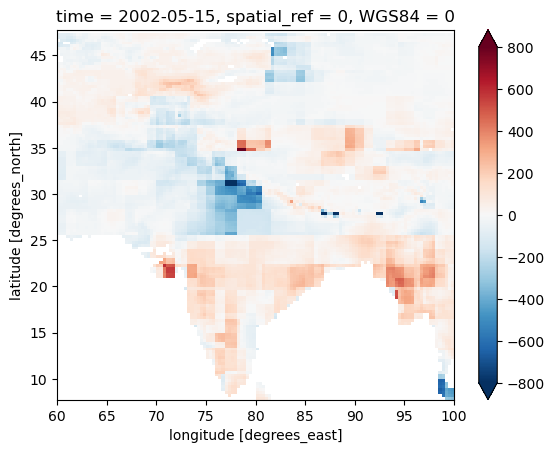

In [6]:
difference_resampled_da = da_gldas - resampled_da_grace
difference_resampled_da[1,:,:].plot(vmin=-800, vmax=800, cmap='RdBu_r')

#### 5. Normalize
"The input and target images are normalized before training"

In [7]:
# dirty fix: replace the first row of the resampled GRACE dataset with the second row to get rid of a numerical error
resampled_da_grace[:,0,:] = resampled_da_grace[:,1,:]

In [8]:
diff_mean = difference_da.mean().item()
diff_std = difference_da.std().item()
norm_difference_da = (difference_da - diff_mean) / diff_std
norm_difference_da.attrs['diff_mean'] = diff_mean
norm_difference_da.attrs['diff_std'] = diff_std
#diff_min = difference_da.min().item()
#diff_max = difference_da.max().item()
#norm_difference_da = (difference_da - diff_min)  / (diff_max - diff_min)

clean_da_gldas = ds_gldas['twsa_gldas'] 

In [9]:
# replace nan with 1e-7 for masking in Keras
norm_difference_da = norm_difference_da.fillna(1e-7)
resampled_da_grace = resampled_da_grace.fillna(1e-7)
clean_da_gldas = clean_da_gldas.fillna(1e-7)

#### 6. Save

In [10]:
xr.merge(
        [norm_difference_da.to_dataset(name='norm_mismatch'), difference_da.to_dataset(name='mismatch'),
         resampled_da_grace.to_dataset(name='grace'), clean_da_gldas.to_dataset(name='gldas')]
    ).to_netcdf('./data/mismatch.nc4')